C:\Users\siddh\AppData\Local\Temp\ipykernel_2904\823606419.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2015-01-01", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


Confusion matrix:
 [[ 96  98]
 [105  92]]
Accuracy: 0.4808  Precision: 0.4842  Recall: 0.4670  F1: 0.4755  ROC-AUC: 0.4703


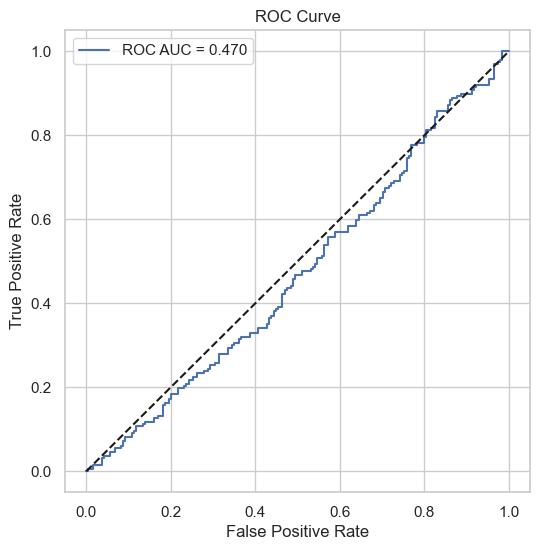

In [2]:
# ======================================
# ONE-SHOT PIPELINE TO BUILD df_final
# ======================================

import numpy as np
import pandas as pd
import yfinance as yf

# --------------------------------------
# 1. Download Data & Compute Returns
# --------------------------------------
df = yf.download("AAPL", start="2015-01-01", end="2023-01-01")

# Safe extraction of adjusted close
prices = df['Close'].dropna()

returns = prices.pct_change().dropna()

# --------------------------------------
# 2. Begin feature table
# --------------------------------------
df_feat = pd.DataFrame()
df_feat["price"] = prices
df_feat["return"] = returns

# --------------------------------------
# 3. Lag Features
# --------------------------------------
df_feat["lag1"] = df_feat["return"].shift(1)
df_feat["lag2"] = df_feat["return"].shift(2)
df_feat["lag5"] = df_feat["return"].shift(5)

# --------------------------------------
# 4. Rolling Means (local trend)
# --------------------------------------
df_feat["roll_mean_5"]  = df_feat["return"].rolling(5).mean()
df_feat["roll_mean_21"] = df_feat["return"].rolling(21).mean()

# --------------------------------------
# 5. Rolling Volatility (risk)
# --------------------------------------
df_feat["roll_vol_5"]  = df_feat["return"].rolling(5).std()
df_feat["roll_vol_21"] = df_feat["return"].rolling(21).std()

# --------------------------------------
# 6. Rolling High/Low (breakout features)
# --------------------------------------
df_feat["roll_max_20"] = df_feat["price"].rolling(20).max()
df_feat["roll_min_20"] = df_feat["price"].rolling(20).min()

# --------------------------------------
# 7. Momentum (multi-period returns)
# --------------------------------------
df_feat["mom_5"]  = df_feat["price"].pct_change(5)
df_feat["mom_21"] = df_feat["price"].pct_change(21)
df_feat["mom_63"] = df_feat["price"].pct_change(63)

# --------------------------------------
# 8. Realized Volatility (RV)
# --------------------------------------
df_feat["rv_21"] = np.sqrt((df_feat["return"]**2).rolling(21).sum() * 252)
df_feat["rv_63"] = np.sqrt((df_feat["return"]**2).rolling(63).sum() * 252)

# --------------------------------------
# 9. Technical Indicators (SMA, EMA)
# --------------------------------------
df_feat["sma_20"] = df_feat["price"].rolling(20).mean()
df_feat["sma_50"] = df_feat["price"].rolling(50).mean()

df_feat["ema_20"] = df_feat["price"].ewm(span=20, adjust=False).mean()
df_feat["ema_50"] = df_feat["price"].ewm(span=50, adjust=False).mean()

# --------------------------------------
# 10. RSI Indicator
# --------------------------------------
delta = df_feat["price"].diff()
up = delta.clip(lower=0)
down = -delta.clip(upper=0)

roll_up = up.rolling(14).mean()
roll_down = down.rolling(14).mean()

rs = roll_up / roll_down
df_feat["rsi_14"] = 100 - (100 / (1 + rs))

# --------------------------------------
# 11. Final cleaning
# --------------------------------------
df_final = df_feat.dropna()

# Show result
df_final.head(), df_final.shape

# Day13: Logistic Regression pipeline (binary up/down prediction)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)

# 1) Prepare data: target = 1 if next-day return > 0 else 0
df = df_final.copy()                    # df_final should already exist
df['target_up'] = (df['return'].shift(-1) > 0).astype(int)
df = df.dropna().copy()                 # drop last row after shift

# 2) Features & target
feature_cols = ["lag1","lag2","lag5",
                "roll_mean_5","roll_mean_21",
                "roll_vol_5","roll_vol_21",
                "mom_5","mom_21","mom_63"]

X = df[feature_cols]
y = df['target_up']

# 3) Time-aware train/test split (no shuffle)
test_size = 0.2
split_idx = int(len(X) * (1 - test_size))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 4) Scale features (fit on train only)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# 5) Fit logistic regression with balanced class weights
# class_weight='balanced' adjusts for imbalance automatically
model = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=1000)
model.fit(X_train_s, y_train)

# 6) Predictions & probabilities
y_pred = model.predict(X_test_s)
y_proba = model.predict_proba(X_test_s)[:,1]   # probability of class 1 (Up)

# 7) Metrics
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
rocauc = roc_auc_score(y_test, y_proba)

print("Confusion matrix:\n", cm)
print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC-AUC: {rocauc:.4f}")

# 8) Plot ROC curve
fpr, tpr, thresh = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC AUC = {rocauc:.3f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
